# Selective Classification for Targeted Sales

## This tutorial shows how to analyze and visualize the uncertainty estimation quality of a classification model using UQ360 and reduce model errors using selective classification framework.


We consider a classification system for targeted sales that predicts the customers in a database to be high- or low-income earners. We illustrate how uncertainty quantification can help end users and developers reduce model errors. When the uncertaines are well calibrated, rejecting model predictions with high uncertainty and delegeting the decisions to expert can reduce costly mistakes. This paradigm is called selective classification [1].

The predictive uncertainty in this classification task is expressed as a confidence score. This confidence score conveys the confidence in the label predicted by a classification model. For probabilistic classifiers, we define this as the probability of the most probable class i.e score = argmax_y p(y|x). 

```
[1] El-Yaniv, R. (2010). On the Foundations of Noise-free Selective Classification. Journal of Machine Learning Research, 11(5).
```


### Use case: 
Let us assume that a seller, Ayo, gets a prediction that customer A belongs to the high-income group. Meanwhile the uncertainty information tells him that this prediction is with 85% confidence. Ayo is new to the system, and he wonders wondering if this is a good enough confidence, and in general, where he should draw the line as a "good confidence score" to rely on the AI system's prediction to make targeted sales. Ayo also would like to compare the model's performance with respect to male and female customers.

Here are the steps involved in the analysis:

#### Step 1: Write import statements.

#### Step 2: Load and pre-process the dataset.

#### Step 3: Train a logistic regression model.

#### Step 4: Compare the calibration and selective classification performace across male and female customers.

#### Step 5: Improve logistic regression model using post-hoc recalibration.

#### Step 6: Train a fairness-aware model and repeat selective classification analysis.

# Step 1: Write import statements.

In [1]:
import sys
sys.path.append("../../")

In [2]:
!pip install 'aif360[all]';

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV

from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, statistical_parity_difference, equal_opportunity_difference
from aif360.sklearn.metrics import generalized_fnr, difference


from aif360.sklearn.inprocessing.adversarial_debiasing import AdversarialDebiasing

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [4]:
from uq360.metrics.classification_metrics import plot_reliability_diagram, plot_risk_vs_rejection_rate

# Step 2: Load and pre-process the dataset.

We will use the UCI adult income dataset [2] to predict the high earners. This dataset contains `48842` instances, mix of continuous and discrete. We will load this dataset using `fetch_adult` utility provided in `AIF360` [3]. To highlight the issues with poor uncertainy estimates we will create an imbalance in the dataset by having a skewed distribution of high earners across gender groups.

Information about dataset features is provided in adult.names

```
[2] https://archive.ics.uci.edu/ml/datasets/adult
[3] https://github.com/Trusted-AI/AIF360
```

In [5]:
X, y, sample_weight = fetch_adult()
X.head()

,,,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
,race,sex,,,,,,,,,,,,,
0,Non-white,Male,25.0,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Non-white,Male,0.0,0.0,40.0,United-States
1,White,Male,38.0,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,White,Male,28.0,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,Non-white,Male,44.0,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Non-white,Male,7688.0,0.0,40.0,United-States
5,White,Male,34.0,Private,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States


In [6]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

In [7]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

In [8]:
X.workclass.cat.remove_unused_categories(inplace=True)
pd.get_dummies(X).head()

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.


,,,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
,race,sex,,,,,,,,,,,,,,,,,,,,,
0,0,1,25.0,7.0,0.0,0.0,40.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,1,38.0,9.0,0.0,0.0,50.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,28.0,12.0,0.0,0.0,40.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,44.0,10.0,7688.0,0.0,40.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,1,34.0,6.0,0.0,0.0,30.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


#### One hot encoding of the features in the dataset.

In [9]:
ohe = make_column_transformer(
        (OneHotEncoder(sparse=False), X.dtypes == 'category'),
        remainder='passthrough')
X_coded  = pd.DataFrame(ohe.fit_transform(X), index=X.index)

In [10]:
(X_trainvalid, X_test,
 y_trainvalid, y_test) = train_test_split(X_coded, y, train_size=0.7, random_state=1234567)

(X_train, X_valid,
 y_train, y_valid) = train_test_split(X_trainvalid, y_trainvalid, train_size=0.7, random_state=1234567)

#### Modify the dataset to simulate data imbalance

The training dataset will have only N samples with positive label for one of the groups. This will create a case where model performs poorly on the group with skewed proportion of postive labels and show up as poorly calibrated uncertainties. Real datasets often have such imbalance and we see how to detect this and which models are robust to this dataset property. 

In [11]:
N = 100
imb_X_train = pd.concat(
    [X_train[~((y_train.index.get_level_values('sex')==0) & (y_train==1))],
    X_train[((y_train.index.get_level_values('sex')==0) & (y_train==1))][:N]],
    axis=0)
imb_y_train = pd.concat(
    [y_train[~((y_train.index.get_level_values('sex')==0) & (y_train==1))],
    y_train[((y_train.index.get_level_values('sex')==0) & (y_train==1))][:N]],
    axis=0)

# Step 3: Train a logistic regression model.

Ayo learns a standard logistic regression model from sklearn which after training achieves an overall accuracy of 83%.

In [12]:
imb_lr = LogisticRegression(solver='lbfgs').fit(imb_X_train, imb_y_train)
imb_lr_y_score = imb_lr.predict_proba(X_test)
imb_lr_y_pred = imb_lr.predict(X_test)
accuracy_score(y_test, imb_lr_y_pred)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.8335667428318715

# Step 4: Compare the calibration and selective classification performace across male and female customers.

To gain overall confidence in the model confidence scores Ayo can look at the expected calibration error (ECE). ECE is the expected difference between the classifier model's accuracy and prediction confidence averaged over multiple prediction bins. ECE is `0` when for any confidence score `p`, the fraction of samples that recieved that score and are correctly predicted is also `p`. Thus, low ECE implies the scores are well calibrated and trusted.

He observes that the ECE metric over the validation set  is 0.03 but this metric has a higher value 0.05 when measured only on instances in the validation in group 1 to which customer A belongs.

Ayo can also look the Reliability Plot (see below) which show the calibration error at each confidence level.

In [13]:
group_1_ids = y_test.index.get_level_values('sex') == 0
group_2_ids = y_test.index.get_level_values('sex') == 1

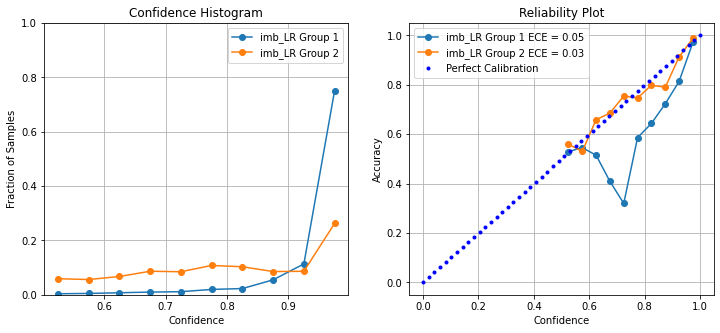

In [14]:
ece_list, accuracies_in_bins_list, frac_samples_in_bins_list, confidences_in_bins_list = plot_reliability_diagram([y_test[group_1_ids], y_test[group_2_ids]],
                         [imb_lr_y_score[group_1_ids], imb_lr_y_score[group_2_ids]],
                         [imb_lr_y_pred[group_1_ids], imb_lr_y_pred[group_2_ids]],
                         plot_label = ["imb_LR Group 1", "imb_LR Group 2"],
                             num_bins=10
                        )

The lower confidence predictions appear to be least accurate for Group 1 and are falling below the ideal calibration line.

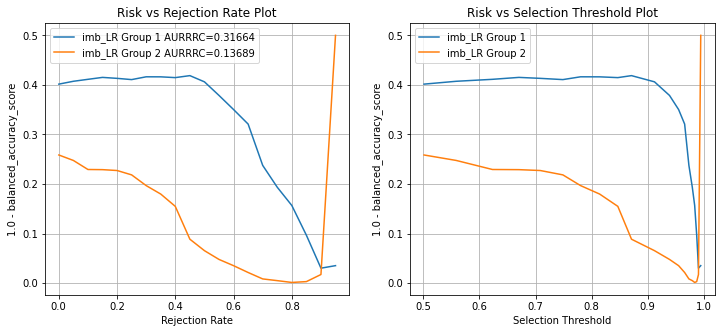

In [15]:
aurrrc_list, rejection_rate_list, selection_thresholds_list, risk_list = plot_risk_vs_rejection_rate([y_test, y_test],
                         [imb_lr_y_score, imb_lr_y_score],
                         [imb_lr_y_pred, imb_lr_y_pred],
                         plot_label = ["imb_LR Group 1", "imb_LR Group 2",],
                          risk_func=balanced_accuracy_score,
                          selection_scores=[None, None],
                          subgroup_ids=[group_1_ids, group_2_ids],
                          num_bins=20
                        )


The poorer ECE for Group 1 also means that as the threshold on the confidence score for accepting a prediction is increased, the reduction in error is marginal compared to the better calibrated Group 2.

# Post-hoc recalibration of the model.

Uncertainty information could also be used by model developers to diagnose and improve the model. For example, Megan is the lead data scientist working on the income prediction model. 


Megan attempts to improve the calibration using a held out set using a post method called Isotonic Regression methods which does not reduce the rejection rate for Group 1 by much. 

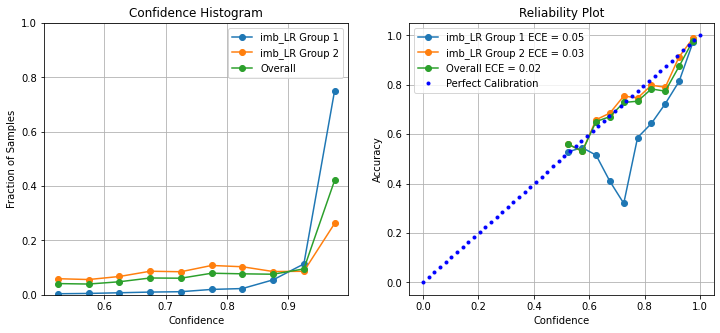

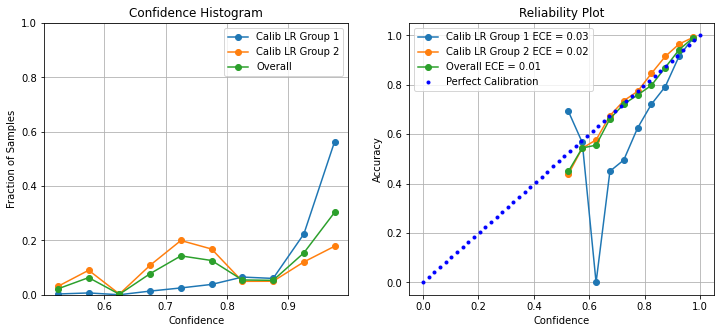

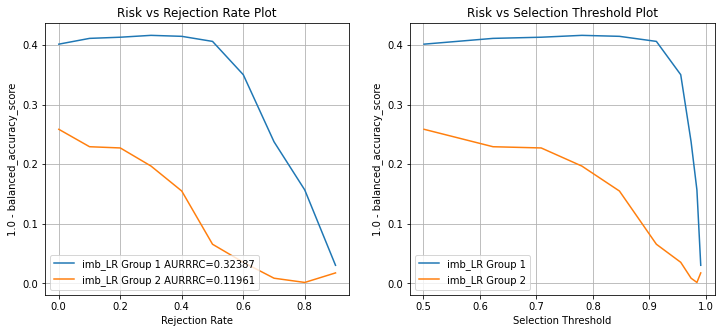

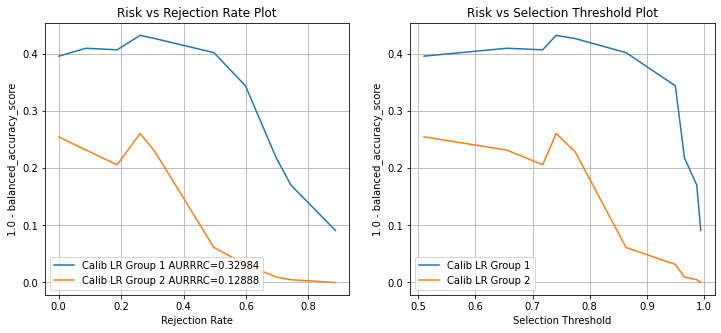

In [16]:
calib_lr = CalibratedClassifierCV(imb_lr, cv='prefit', method='isotonic')
calib_lr.fit(X_valid, y_valid)
calib_lr_y_score = calib_lr.predict_proba(X_test)
#calib_lr_y_score = np.concatenate([1.0 - calib_lr_y_score, calib_lr_y_score])
calib_lr_y_pred = np.argmax(calib_lr_y_score, axis=1)


_ = plot_reliability_diagram([y_test[group_1_ids], y_test[group_2_ids], y_test],
                         [imb_lr_y_score[group_1_ids], imb_lr_y_score[group_2_ids], imb_lr_y_score],
                         [imb_lr_y_pred[group_1_ids], imb_lr_y_pred[group_2_ids], imb_lr_y_pred],
                         plot_label = ["imb_LR Group 1", "imb_LR Group 2", "Overall"],
                             
                        )


_ = plot_reliability_diagram([y_test[group_1_ids], y_test[group_2_ids], y_test],
                         [calib_lr_y_score[group_1_ids], calib_lr_y_score[group_2_ids], calib_lr_y_score],
                         [calib_lr_y_pred[group_1_ids], calib_lr_y_pred[group_2_ids], calib_lr_y_pred],
                         plot_label = ["Calib LR Group 1", "Calib LR Group 2", "Overall"]
                        )


_ = plot_risk_vs_rejection_rate([y_test, y_test],
                         [imb_lr_y_score, imb_lr_y_score],
                         [imb_lr_y_pred, imb_lr_y_pred],
                         plot_label = ["imb_LR Group 1", "imb_LR Group 2",],
                          risk_func=balanced_accuracy_score,
                          selection_scores=[None, None],
                          subgroup_ids=[group_1_ids, group_2_ids],
                          num_bins=10
                        )

_ = plot_risk_vs_rejection_rate([y_test, y_test],
                         [calib_lr_y_score, calib_lr_y_score],
                         [calib_lr_y_pred, calib_lr_y_pred],
                         plot_label = ["Calib LR Group 1", "Calib LR Group 2",],
                          risk_func=balanced_accuracy_score,
                          selection_scores=[None, None],
                          subgroup_ids=[group_1_ids, group_2_ids],
                          num_bins=10
                        )


# Train a fairness aware model

Next she trains a new prediction model called Adversarial debiasing that explicitly enforces that the confidence scores are independent of the group.

In [17]:

adv_deb = AdversarialDebiasing(prot_attr='sex', random_state=1234567)
adv_deb.fit(imb_X_train, imb_y_train)

adv_y_score = adv_deb.predict_proba(X_test)
adv_y_pred = adv_deb.predict(X_test)
accuracy_score(y_test, adv_y_pred)

0.8180142994029631

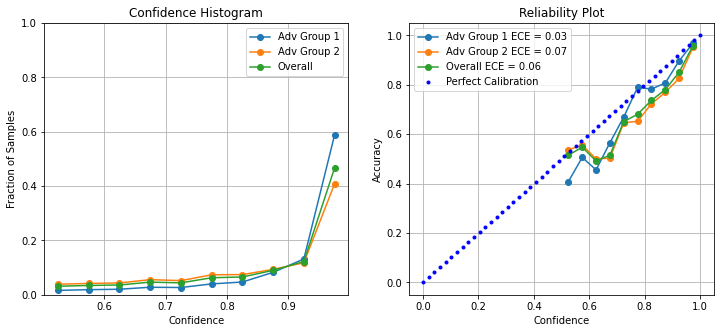

In [18]:
_ = plot_reliability_diagram([y_test[group_1_ids], y_test[group_2_ids], y_test],
                         [adv_y_score[group_1_ids], adv_y_score[group_2_ids], adv_y_score],
                         [adv_y_pred[group_1_ids], adv_y_pred[group_2_ids], adv_y_pred],
                         plot_label = ["Adv Group 1", "Adv Group 2", "Overall"]
                        )

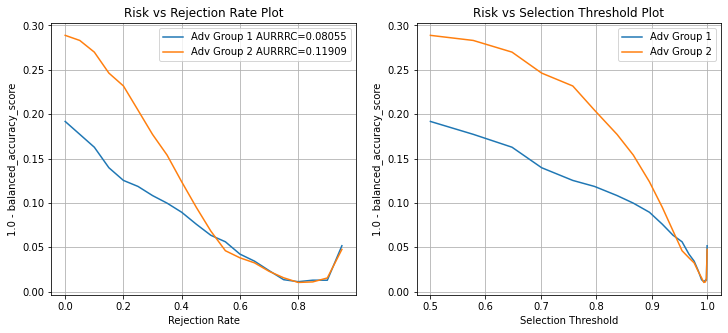

In [19]:
_ = plot_risk_vs_rejection_rate([y_test, y_test],
                         [adv_y_score, adv_y_score],
                         [adv_y_pred, adv_y_pred],
                         plot_label = ["Adv Group 1", "Adv Group 2",],
                          risk_func=balanced_accuracy_score,
                          selection_scores=[None, None],
                          subgroup_ids=[group_1_ids, group_2_ids],
                          num_bins=20
                        )

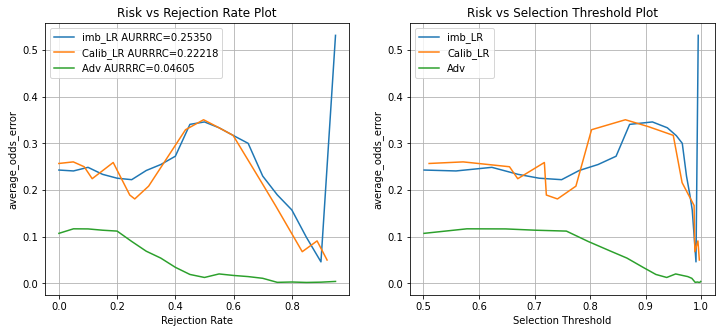

In [20]:
_ = plot_risk_vs_rejection_rate([y_test, y_test, y_test],
                         [imb_lr_y_score, calib_lr_y_score, adv_y_score],
                         [imb_lr_y_pred, calib_lr_y_pred, adv_y_pred],
                         plot_label = ["imb_LR", "Calib_LR", "Adv"],
                          selection_scores=[None, None, None],
                          subgroup_ids=[None, None, None],
                         risk_func=average_odds_error,
                          attributes='sex',
                          num_bins=20
                        )

For the same error rate, the rejection rates for Group 1 and 2, in this case, improves to 0.4 and 0.5, respectively. The corresponding confidence threshold for Group 1 and 2 are 0.9 and 0.92.